In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report
import torch
import gc
import warnings

warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


### Load data

In [2]:
# Load CSV
df = pd.read_csv('../data/cleaned_for_tfidf.csv')
print(f"Loaded {len(df):,} rows\n")

# Filter out manual labeling set
absa_ids = set(pd.read_csv('../data/absa_training_set.csv', usecols=['review_id'])['review_id'].astype(str))
df = df[~df['review_id'].isin(absa_ids)].reset_index(drop=True)
print(f"After filtering absa set: {len(df):,} rows")
df.head(3)

Loaded 22,624,379 rows

After filtering absa set: 22,614,379 rows


,review_id,user_id,rating,text,gmap_id,product_quality_positive,product_quality_negative,service_positive,service_negative,wait_time_positive,wait_time_negative,price_value_positive,price_value_negative,cleanliness_positive,cleanliness_negative,atmosphere_positive,atmosphere_negative,general_positive,general_negative,text_baseline
0,456e420929727f933dbaed63eff45cde53c7b92438cf0d...,-1,5,"Easy process, extremely friendly, helpful staf...",0x80960c29f2e3bf29:0x4b291f0d275a5699,0,0,1,0,0,0,0,0,0,0,0,0,0,0,easy process extremely friendly helpful staff ...
1,ea2ad448a8b443c1c42c5d4ca9dd84d02fe9f2f110b993...,-1,5,My girlfriends and I took a weekend ski trip t...,0x80960c29f2e3bf29:0x4b291f0d275a5699,0,0,1,0,0,0,1,0,0,0,0,0,1,0,my girlfriends and i took a weekend ski trip t...
2,77efbe6a6f4d27512b59bb2f878b0ac8b533aa03a11fb7...,-1,5,The team at Black Tie never disappoints our se...,0x80960c29f2e3bf29:0x4b291f0d275a5699,0,0,1,0,0,0,0,0,0,0,0,0,1,0,the team at black tie never disappoints our se...


# TF-IDF Vectorization

In [3]:
# Keep negation words for ngrams
stop_words = [w for w in text.ENGLISH_STOP_WORDS if w not in ('not', 'no', 'never', 'nor')]

print("Fitting TF-IDF vectorizer...")
tfidf = TfidfVectorizer(
    max_features=10000,      # Limits vocabulary to top 10k most frequent words to reduce dimensionality and speed up training
    stop_words=stop_words,   # Removes common words like "the", "is", "and" that don't carry sentiment + negation handling
    min_df=500,              # Ignores words appearing in fewer than 500 documents (removes typos/rare words), only keeps well-established terms
    max_df=0.5,              # Ignores words appearing in more than 50% of documents (removes overly common words, "noise")
    ngram_range=(1, 2)       # (1, 2) - unigrams AND bigrams (captures phrases like "not good", "really bad")
    )

Fitting TF-IDF vectorizer...


### Train/test split

In [4]:
# 14 binary labels (7 aspects x 2 sentiments)
aspect_cols = [
             'product_quality_positive', 'product_quality_negative',
             'service_positive', 'service_negative',
             'wait_time_positive', 'wait_time_negative',
             'price_value_positive', 'price_value_negative',
             'cleanliness_positive', 'cleanliness_negative',
             'atmosphere_positive', 'atmosphere_negative',
             'general_positive', 'general_negative'
             ]

print("Splitting data...")
X = tfidf.fit_transform(df['text_baseline'].fillna('')) # fillna to handle nan values
y = df[aspect_cols].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, # 90/10 split (we have a lot of data, 10% is 2.2M for testing)
                                                    random_state=2)

print(f"Train size: {X_train.shape[0]:,}")
print(f"Test size:  {X_test.shape[0]:,}\n")

Splitting data...
Train size: 20,352,941
Test size:  2,261,438



# Logistic Regression (Baseline)


### Train 

In [5]:
print("Training Logistic Regression...")
print()

# MultiOutputClassifier trains separate binary classifiers for each of the 14 aspect-sentiment labels
clf_1 = MultiOutputClassifier(
    LogisticRegressionCV( 
        cv=3,                  # Testing at 3 to start for speed
        scoring='f1_weighted',
        random_state=2,
        n_jobs=1,
        max_iter=500
    ),
    n_jobs=-1
)

clf_1.fit(X_train, y_train)

Training Logistic Regression...



,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.A :term:`predict_proba` method will be exposed only if `estimator` implementsit.,LogisticRegre...'f1_weighted')
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",-1
,"Cs Cs: int or list of floats, default=10Each of the values in Cs describes the inverse of regularizationstrength. If Cs is as an int, then a grid of Cs values are chosenin a logarithmic scale between 1e-4 and 1e4.Like in support vector machines, smaller values specify strongerregularization.",10
,"l1_ratios l1_ratios: array-like of shape (n_l1_ratios), default=NoneFloats between 0 and 1 passed as Elastic-Net mixing parameter (scaling betweenL1 and L2 penalties). For `l1_ratio = 0` the penalty is an L2 penalty. For`l1_ratio = 1` it is an L1 penalty. For `0 < l1_ratio < 1`, the penalty is acombination of L1 and L2.All the values of the given array-like are tested by cross-validation and theone giving the best prediction score is used... warning:: Certain values of `l1_ratios`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... deprecated:: 1.8 `l1_ratios=None` is deprecated in 1.8 and will raise an error in version 1.10. Default value will change from `None` to `(0.0,)` in version 1.10.",'warn'
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"cv cv: int or cross-validation generator, default=NoneThe default cross-validation generator used is Stratified K-Folds.If an integer is provided, it specifies the number of folds, `n_folds`, used.See the module :mod:`sklearn.model_selection` module for thelist of possible cross-validation objects... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer dual=False whenn_samples > n_features.",False
,"penalty penalty: {'l1', 'l2', 'elasticnet'}, default='l2'Specify the norm of the penalty:- `'l2'`: add a L2 penalty term (used by default);- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"scoring scoring: str or callable, default=NoneThe scoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)``. See :ref:`scoring_callable` for details.- `None`: :ref:`accuracy ` is used.",'f1_weighted'
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well fo

### Evaluate

In [7]:
# with negation
y_pred_1 = clf_1.predict(X_test)

print("Logistic Regression (Baseline + Negation):")
print()
print(f"Training Accuracy: {clf_1.score(X_train, y_train):.4f}")
print(f"Test Accuracy:     {clf_1.score(X_test, y_test):.4f}")
print()
print(f"F1 Score (macro):    {f1_score(y_test, y_pred_1, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_1, average='weighted'):.4f}")
print()

print("Classification Report:")
print(classification_report(y_test, y_pred_1, target_names=aspect_cols, zero_division=0))

Logistic Regression (Baseline + Negation):

Training Accuracy: 0.7719
Test Accuracy:     0.7715

F1 Score (macro):    0.7330
F1 Score (weighted): 0.8584

Classification Report:
                          precision    recall  f1-score   support

product_quality_positive       0.92      0.89      0.91    699524
product_quality_negative       0.79      0.55      0.65    170629
        service_positive       0.94      0.91      0.92    557547
        service_negative       0.84      0.61      0.71    146304
      wait_time_positive       0.88      0.76      0.82    280513
      wait_time_negative       0.77      0.53      0.63    105530
    price_value_positive       0.89      0.82      0.86    255333
    price_value_negative       0.76      0.43      0.55     79571
    cleanliness_positive       0.91      0.84      0.87    114739
    cleanliness_negative       0.83      0.45      0.58     35854
     atmosphere_positive       0.90      0.85      0.87    186086
     atmosphere_negative      

In [7]:
# Before adding in negation stop words
y_pred_1 = clf_1.predict(X_test)

print("Logistic Regression (Baseline):")
print()
print(f"Training Accuracy: {clf_1.score(X_train, y_train):.4f}")
print(f"Test Accuracy:     {clf_1.score(X_test, y_test):.4f}")
print()
print(f"F1 Score (macro):    {f1_score(y_test, y_pred_1, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_1, average='weighted'):.4f}")
print()

print("Classification Report:")
print(classification_report(y_test, y_pred_1, target_names=aspect_cols, zero_division=0))

Logistic Regression (Baseline):

Training Accuracy: 0.7599
Test Accuracy:     0.7594

F1 Score (macro):    0.7137
F1 Score (weighted): 0.8475

Classification Report:
                          precision    recall  f1-score   support

product_quality_positive       0.92      0.89      0.90    699524
product_quality_negative       0.79      0.51      0.62    170629
        service_positive       0.93      0.91      0.92    557547
        service_negative       0.84      0.59      0.70    146304
      wait_time_positive       0.87      0.76      0.81    280513
      wait_time_negative       0.77      0.48      0.59    105530
    price_value_positive       0.89      0.81      0.85    255333
    price_value_negative       0.73      0.40      0.52     79571
    cleanliness_positive       0.90      0.83      0.87    114739
    cleanliness_negative       0.75      0.43      0.55     35854
     atmosphere_positive       0.89      0.85      0.87    186086
     atmosphere_negative       0.58      

In [7]:
# Old results before updating weak supervision
y_pred_1 = clf_1.predict(X_test)

print("Logistic Regression (Baseline):")
print()
print(f"Training Accuracy: {clf_1.score(X_train, y_train):.4f}")
print(f"Test Accuracy:     {clf_1.score(X_test, y_test):.4f}")
print()
print(f"F1 Score (macro):    {f1_score(y_test, y_pred_1, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_1, average='weighted'):.4f}")
print()

print("Classification Report:")
print(classification_report(y_test, y_pred_1))
print()
print("\nLabel Index Key:")
for i, label in enumerate(aspect_cols):
    print(f"  {i}: {label}")

Logistic Regression (Baseline):

Training Accuracy: 0.7812
Test Accuracy:     0.7814

F1 Score (macro):    0.4786
F1 Score (weighted): 0.7698

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91    652525
           1       0.76      0.39      0.52     82540
           2       0.46      0.06      0.10     70495
           3       0.93      0.91      0.92    558326
           4       0.81      0.59      0.68     94898
           5       0.38      0.06      0.11     52074
           6       0.87      0.75      0.81    281182
           7       0.74      0.40      0.52     63970
           8       0.35      0.03      0.06     42068
           9       0.89      0.85      0.87    254752
          10       0.65      0.32      0.43     43259
          11       0.37      0.09      0.14     36230
          12       0.90      0.84      0.87    114873
          13       0.75      0.34      0.47     20552
          14       0.29

### Baseline analysis
- The baseline TF-IDF model fails to predict neutral sentiment labels (0% precision/recall) due to significant class imbalances.
- Neutral reviews comprise only 7% of the dataset while positive reviews dominate at 64%. The model optimizes for overall accuracy and ignores rare labels.
- This is a strong indication we need to address class imbalance. 

In [8]:
# Clear memory to train another model
del clf_1, y_pred_1
gc.collect()

4680

## Logistic Regression (Weighted Classes)


### Train & evaluate 

In [9]:
print("Training Logistic Regression...")
print()

# MultiOutputClassifier trains separate binary classifiers for each of the 14 aspect-sentiment labels
clf_2 = MultiOutputClassifier(
    LogisticRegressionCV( 
        cv=3,                  # Testing at 3 for speed
        scoring='f1_weighted',
        random_state=2,
        n_jobs=1,
        max_iter=500,
        class_weight='balanced' # Classes will all be equal in weight
    ),
    n_jobs=-1
)

clf_2.fit(X_train, y_train)

Training Logistic Regression...



,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.A :term:`predict_proba` method will be exposed only if `estimator` implementsit.,LogisticRegre...'f1_weighted')
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",-1
,"Cs Cs: int or list of floats, default=10Each of the values in Cs describes the inverse of regularizationstrength. If Cs is as an int, then a grid of Cs values are chosenin a logarithmic scale between 1e-4 and 1e4.Like in support vector machines, smaller values specify strongerregularization.",10
,"l1_ratios l1_ratios: array-like of shape (n_l1_ratios), default=NoneFloats between 0 and 1 passed as Elastic-Net mixing parameter (scaling betweenL1 and L2 penalties). For `l1_ratio = 0` the penalty is an L2 penalty. For`l1_ratio = 1` it is an L1 penalty. For `0 < l1_ratio < 1`, the penalty is acombination of L1 and L2.All the values of the given array-like are tested by cross-validation and theone giving the best prediction score is used... warning:: Certain values of `l1_ratios`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... deprecated:: 1.8 `l1_ratios=None` is deprecated in 1.8 and will raise an error in version 1.10. Default value will change from `None` to `(0.0,)` in version 1.10.",'warn'
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"cv cv: int or cross-validation generator, default=NoneThe default cross-validation generator used is Stratified K-Folds.If an integer is provided, it specifies the number of folds, `n_folds`, used.See the module :mod:`sklearn.model_selection` module for thelist of possible cross-validation objects... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer dual=False whenn_samples > n_features.",False
,"penalty penalty: {'l1', 'l2', 'elasticnet'}, default='l2'Specify the norm of the penalty:- `'l2'`: add a L2 penalty term (used by default);- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"scoring scoring: str or callable, default=NoneThe scoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)``. See :ref:`scoring_callable` for details.- `None`: :ref:`accuracy ` is used.",'f1_weighted'
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well fo

In [10]:
y_pred_2 = clf_2.predict(X_test)

print("Logistic Regression (Weighted Clases - Balanced + Negation):")
print()
print(f"Training Accuracy: {clf_2.score(X_train, y_train):.4f}")
print(f"Test Accuracy:     {clf_2.score(X_test, y_test):.4f}")
print()
print(f"F1 Score (macro):    {f1_score(y_test, y_pred_2, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_2, average='weighted'):.4f}")    
print()

print("Classification Report:")
print(classification_report(y_test, y_pred_2, target_names=aspect_cols, zero_division=0))

Logistic Regression (Weighted Clases - Balanced + Negation):

Training Accuracy: 0.5980
Test Accuracy:     0.5976

F1 Score (macro):    0.6997
F1 Score (weighted): 0.8510

Classification Report:
                          precision    recall  f1-score   support

product_quality_positive       0.89      0.95      0.92    699524
product_quality_negative       0.41      0.91      0.57    170629
        service_positive       0.90      0.97      0.93    557547
        service_negative       0.46      0.93      0.62    146304
      wait_time_positive       0.76      0.95      0.85    280513
      wait_time_negative       0.39      0.94      0.55    105530
    price_value_positive       0.81      0.98      0.89    255333
    price_value_negative       0.33      0.96      0.49     79571
    cleanliness_positive       0.82      0.95      0.88    114739
    cleanliness_negative       0.24      0.96      0.39     35854
     atmosphere_positive       0.82      0.99      0.90    186086
     atmosph

In [12]:
y_pred_2 = clf_2.predict(X_test)

print("Logistic Regression (Weighted Clases - Balanced):")
print()
print(f"Training Accuracy: {clf_2.score(X_train, y_train):.4f}")
print(f"Test Accuracy:     {clf_2.score(X_test, y_test):.4f}")
print()
print(f"F1 Score (macro):    {f1_score(y_test, y_pred_2, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_2, average='weighted'):.4f}")    
print()

print("Classification Report:")
print(classification_report(y_test, y_pred_2, target_names=aspect_cols, zero_division=0))

Logistic Regression (Weighted Clases - Balanced):

Training Accuracy: 0.5768
Test Accuracy:     0.5765

F1 Score (macro):    0.6936
F1 Score (weighted): 0.8453

Classification Report:
                          precision    recall  f1-score   support

product_quality_positive       0.89      0.95      0.92    699524
product_quality_negative       0.41      0.91      0.56    170629
        service_positive       0.89      0.96      0.93    557547
        service_negative       0.45      0.92      0.60    146304
      wait_time_positive       0.76      0.95      0.84    280513
      wait_time_negative       0.38      0.94      0.54    105530
    price_value_positive       0.80      0.98      0.88    255333
    price_value_negative       0.32      0.96      0.48     79571
    cleanliness_positive       0.82      0.95      0.88    114739
    cleanliness_negative       0.25      0.97      0.39     35854
     atmosphere_positive       0.82      0.99      0.90    186086
     atmosphere_negativ

In [15]:
# Old results before updating weak supervision
y_pred_2 = clf_2.predict(X_test)

print("Logistic Regression (Weighted Clases):")
print()
print(f"Training Accuracy: {clf_2.score(X_train, y_train):.4f}")
print(f"Test Accuracy:     {clf_2.score(X_test, y_test):.4f}")
print()
print(f"F1 Score (macro):    {f1_score(y_test, y_pred_2, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_2, average='weighted'):.4f}")    
print()

print("Classification Report:")
print(classification_report(y_test, y_pred_2))
print()
print("\nLabel Index Key:")
for i, label in enumerate(label_cols):
    print(f"  {i}: {label}")


Logistic Regression (Weighted Clases):
Training Accuracy: 0.5529
Test Accuracy:     0.5529
F1 Score (macro):    0.5080
F1 Score (weighted): 0.7863


Label Index Key:
  0: food_quality_positive
  1: food_quality_negative
  2: food_quality_neutral
  3: service_positive
  4: service_negative
  5: service_neutral
  6: wait_time_positive
  7: wait_time_negative
  8: wait_time_neutral
  9: price_value_positive
  10: price_value_negative
  11: price_value_neutral
  12: cleanliness_positive
  13: cleanliness_negative
  14: cleanliness_neutral
  15: atmosphere_positive
  16: atmosphere_negative
  17: atmosphere_neutral

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92    652953
           1       0.30      0.94      0.46     83229
           2       0.16      0.88      0.27     70289
           3       0.89      0.96      0.93    558125
           4       0.42      0.95      0.59     95145
           5       0.13      0.89

/Users/macmini/.venvs/base/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/macmini/.venvs/base/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/macmini/.venvs/base/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.

### Weighted classes analysis


In [18]:
# Clear memory to train another model
del clf_2, y_pred_2
gc.collect()

2693

In [11]:
print("Training Logistic Regression...")
print()

# MultiOutputClassifier trains separate binary classifiers for each of the 14 aspect-sentiment labels
clf_3 = MultiOutputClassifier(
    LogisticRegressionCV( 
        cv=3,                  # Testing at 3 for speed
        scoring='f1_weighted',
        random_state=2,
        n_jobs=1,
        max_iter=500,
        class_weight={0: 1, 1: 2}  # penalize missing negatives 2x 
    ),
    n_jobs=-1
)

clf_3.fit(X_train, y_train)

Training Logistic Regression...



,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.A :term:`predict_proba` method will be exposed only if `estimator` implementsit.,LogisticRegre...'f1_weighted')
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",-1
,"Cs Cs: int or list of floats, default=10Each of the values in Cs describes the inverse of regularizationstrength. If Cs is as an int, then a grid of Cs values are chosenin a logarithmic scale between 1e-4 and 1e4.Like in support vector machines, smaller values specify strongerregularization.",10
,"l1_ratios l1_ratios: array-like of shape (n_l1_ratios), default=NoneFloats between 0 and 1 passed as Elastic-Net mixing parameter (scaling betweenL1 and L2 penalties). For `l1_ratio = 0` the penalty is an L2 penalty. For`l1_ratio = 1` it is an L1 penalty. For `0 < l1_ratio < 1`, the penalty is acombination of L1 and L2.All the values of the given array-like are tested by cross-validation and theone giving the best prediction score is used... warning:: Certain values of `l1_ratios`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... deprecated:: 1.8 `l1_ratios=None` is deprecated in 1.8 and will raise an error in version 1.10. Default value will change from `None` to `(0.0,)` in version 1.10.",'warn'
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"cv cv: int or cross-validation generator, default=NoneThe default cross-validation generator used is Stratified K-Folds.If an integer is provided, it specifies the number of folds, `n_folds`, used.See the module :mod:`sklearn.model_selection` module for thelist of possible cross-validation objects... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer dual=False whenn_samples > n_features.",False
,"penalty penalty: {'l1', 'l2', 'elasticnet'}, default='l2'Specify the norm of the penalty:- `'l2'`: add a L2 penalty term (used by default);- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"scoring scoring: str or callable, default=NoneThe scoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)``. See :ref:`scoring_callable` for details.- `None`: :ref:`accuracy ` is used.",'f1_weighted'
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well fo

In [12]:
y_pred_3 = clf_3.predict(X_test)

print("Logistic Regression (Weighted Clases (Neg 2x Penalty) + Negation):")
print()
print(f"Training Accuracy: {clf_3.score(X_train, y_train):.4f}")
print(f"Test Accuracy:     {clf_3.score(X_test, y_test):.4f}")
print()
print(f"F1 Score (macro):    {f1_score(y_test, y_pred_3, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_3, average='weighted'):.4f}")    
print()

print("Classification Report:")
print(classification_report(y_test, y_pred_3, target_names=aspect_cols, zero_division=0))

Logistic Regression (Weighted Clases (Neg 2x Penalty) + Negation):

Training Accuracy: 0.7940
Test Accuracy:     0.7939

F1 Score (macro):    0.7777
F1 Score (weighted): 0.8799

Classification Report:
                          precision    recall  f1-score   support

product_quality_positive       0.90      0.94      0.92    699524
product_quality_negative       0.70      0.69      0.69    170629
        service_positive       0.91      0.95      0.93    557547
        service_negative       0.77      0.73      0.75    146304
      wait_time_positive       0.84      0.87      0.86    280513
      wait_time_negative       0.70      0.67      0.68    105530
    price_value_positive       0.87      0.91      0.89    255333
    price_value_negative       0.67      0.61      0.64     79571
    cleanliness_positive       0.88      0.91      0.90    114739
    cleanliness_negative       0.72      0.60      0.65     35854
     atmosphere_positive       0.87      0.93      0.90    186086
     a

In [ ]:
# Best results so far! 2x penalty on negative reviews 

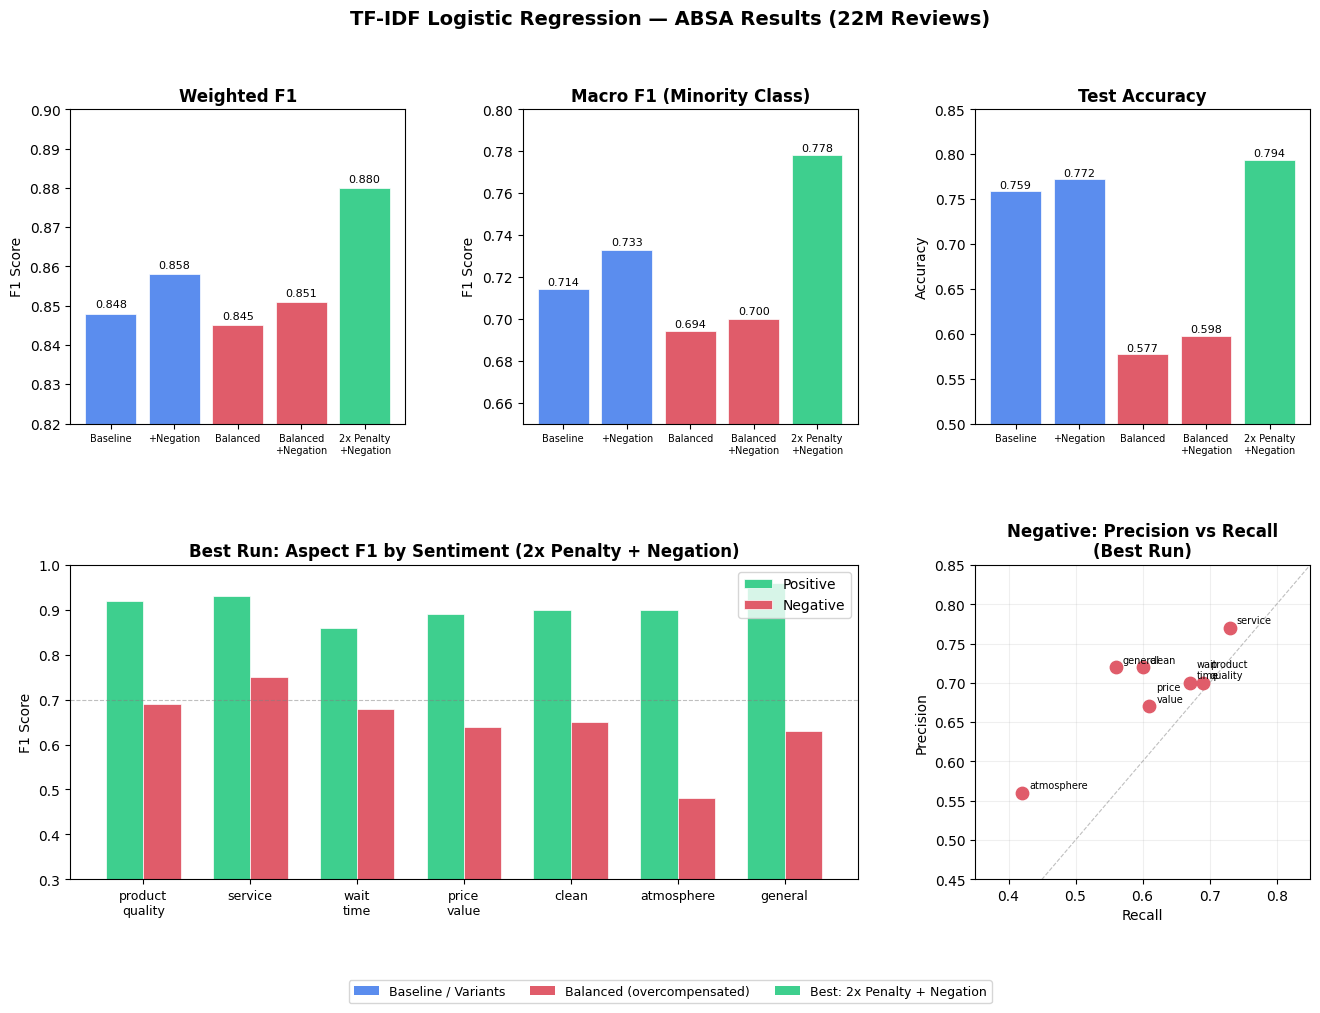

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

runs       = ['Baseline', '+Negation', 'Balanced', 'Balanced\n+Negation', '2x Penalty\n+Negation']
weighted   = [0.848, 0.858, 0.845, 0.851, 0.880]
macro      = [0.714, 0.733, 0.694, 0.700, 0.778]
accuracy   = [0.759, 0.772, 0.577, 0.598, 0.794]

aspects = ['product\nquality', 'service', 'wait\ntime', 'price\nvalue', 'clean', 'atmosphere', 'general']
pos_f1  = [0.92, 0.93, 0.86, 0.89, 0.90, 0.90, 0.96]
neg_f1  = [0.69, 0.75, 0.68, 0.64, 0.65, 0.48, 0.63]

colors = ['#5b8dee', '#5b8dee', '#e05c6a', '#e05c6a', '#3ecf8e']

fig = plt.figure(figsize=(16, 10))
fig.suptitle('TF-IDF Logistic Regression — ABSA Results (22M Reviews)', fontsize=14, fontweight='bold', y=0.98)
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.45, wspace=0.35)

# 1 - Weighted F1
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(runs, weighted, color=colors, edgecolor='white', linewidth=0.5)
ax1.set_ylim(0.82, 0.90)
ax1.set_title('Weighted F1', fontweight='bold')
ax1.set_ylabel('F1 Score')
for bar, val in zip(bars, weighted):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
ax1.tick_params(axis='x', labelsize=7)

# 2 - Macro F1
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(runs, macro, color=colors, edgecolor='white', linewidth=0.5)
ax2.set_ylim(0.65, 0.80)
ax2.set_title('Macro F1 (Minority Class)', fontweight='bold')
ax2.set_ylabel('F1 Score')
for bar, val in zip(bars, macro):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
ax2.tick_params(axis='x', labelsize=7)

# 3 - Accuracy
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(runs, accuracy, color=colors, edgecolor='white', linewidth=0.5)
ax3.set_ylim(0.50, 0.85)
ax3.set_title('Test Accuracy', fontweight='bold')
ax3.set_ylabel('Accuracy')
for bar, val in zip(bars, accuracy):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
ax3.tick_params(axis='x', labelsize=7)

# 4 - Aspect F1 best run grouped
ax4 = fig.add_subplot(gs[1, :2])
x = np.arange(len(aspects))
width = 0.35
ax4.bar(x - width/2, pos_f1, width, label='Positive', color='#3ecf8e', edgecolor='white', linewidth=0.5)
ax4.bar(x + width/2, neg_f1, width, label='Negative', color='#e05c6a', edgecolor='white', linewidth=0.5)
ax4.set_xticks(x)
ax4.set_xticklabels(aspects, fontsize=9)
ax4.set_ylim(0.3, 1.0)
ax4.set_title('Best Run: Aspect F1 by Sentiment (2x Penalty + Negation)', fontweight='bold')
ax4.set_ylabel('F1 Score')
ax4.legend()
ax4.axhline(0.7, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# 5 - Precision vs Recall scatter best run
precision_neg = [0.70, 0.77, 0.70, 0.67, 0.72, 0.56, 0.72]
recall_neg    = [0.69, 0.73, 0.67, 0.61, 0.60, 0.42, 0.56]
ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(recall_neg, precision_neg, color='#e05c6a', s=80, zorder=3)
for i, asp in enumerate(aspects):
    ax5.annotate(asp, (recall_neg[i], precision_neg[i]), textcoords='offset points', xytext=(5, 3), fontsize=7)
ax5.plot([0, 1], [0, 1], 'gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax5.set_xlim(0.35, 0.85)
ax5.set_ylim(0.45, 0.85)
ax5.set_xlabel('Recall')
ax5.set_ylabel('Precision')
ax5.set_title('Negative: Precision vs Recall\n(Best Run)', fontweight='bold')
ax5.grid(True, alpha=0.2)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#5b8dee', label='Baseline / Variants'),
                   Patch(facecolor='#e05c6a', label='Balanced (overcompensated)'),
                   Patch(facecolor='#3ecf8e', label='Best: 2x Penalty + Negation')]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=9, bbox_to_anchor=(0.5, -0.02))

plt.savefig('tfidf_summary.png', dpi=150, bbox_inches='tight')
plt.show()